<a href="https://colab.research.google.com/github/dmosh/building_density/blob/main/density.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Loading neccessary libraries
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random
import re
import io
from google.cloud import storage
import tensorflow as tf
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Input, Dense, Flatten, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [ ]:
# mount your drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Create a Cloud Storage client
storage_client = storage.Client()

# Get the bucket where the training data is stored
bucket = storage_client.bucket('xcob-bucket-1')

# Get the object where the training data is stored
object_training = bucket.blob('dataset/training/training.csv')

# Download the training data from Cloud Storage
training_data = object_training.download_as_string().decode('utf-8')

# Create a StringIO object from the training data
with io.StringIO(training_data) as f:
    training = pd.read_csv(f)

# Get the object where the testing data is stored
object_testing = bucket.blob('dataset/test/testing.csv')

# Download the testing data from Cloud Storage
testing_data = object_testing.download_as_string().decode('utf-8')

# Create a StringIO object from the testing data
with io.StringIO(testing_data) as f:
    testing = pd.read_csv(f)


In [ ]:
training.head()
#print(training.shape)
#print(testing.shape)

,input,label
0,/content/drive/MyDrive/Colab Notebooks/buildin...,/content/drive/MyDrive/Colab Notebooks/buildin...
1,/content/drive/MyDrive/Colab Notebooks/buildin...,/content/drive/MyDrive/Colab Notebooks/buildin...
2,/content/drive/MyDrive/Colab Notebooks/buildin...,/content/drive/MyDrive/Colab Notebooks/buildin...
3,/content/drive/MyDrive/Colab Notebooks/buildin...,/content/drive/MyDrive/Colab Notebooks/buildin...
4,/content/drive/MyDrive/Colab Notebooks/buildin...,/content/drive/MyDrive/Colab Notebooks/buildin...


In [ ]:
#Access sample images
# Access the "input" and "label" columns
input_paths = training["input"]
label_paths = training["label"]

#Access validation images
tinput_paths = testing["input"]
tlabel_paths = testing["label"]

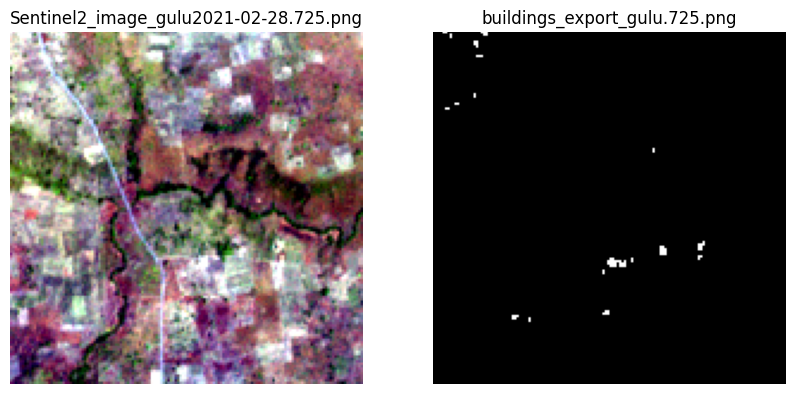

In [ ]:
# Initialize a client to interact with GCS (make sure you've set up GCS credentials)
client = storage.Client()

def visualize_random_image_pair(input_paths, label_paths):
    # Select a random index
    random_index = random.randint(0, len(input_paths) - 1)

    # Get the image paths at the random index
    input_path = input_paths[random_index]
    label_path = label_paths[random_index]

    # Extract file names from image paths
    input_filename = os.path.basename(input_path)
    label_filename = os.path.basename(label_path)

    # Load images from GCS
    input_blob = client.get_bucket('xcob-bucket-1').blob(input_path)
    label_blob = client.get_bucket('xcob-bucket-1').blob(label_path)

    # Download image data from GCS
    input_image_data = input_blob.download_as_string()
    label_image_data = label_blob.download_as_string()

    # Decode the image data using OpenCV
    img1 = cv2.imdecode(np.frombuffer(input_image_data, np.uint8), -1)
    img2 = cv2.imdecode(np.frombuffer(label_image_data, np.uint8), -1)

    # Plot the random image pair with titles
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title(f"{input_filename}")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title(f"{label_filename}")
    plt.axis("off")
    plt.show()

# Read the CSV file into a DataFrame
df = pd.read_csv('your-csv-file.csv')

# Extract the input and label paths from the DataFrame
input_paths = df['input'].tolist()
label_paths = df['label'].tolist()

# Visualize a random pair of images from the training data
visualize_random_image_pair(input_paths, label_paths)


In [ ]:
# Load data for training and validation
desired_height, desired_width = (148, 148)

# Function to load, preprocess, and normalize an image
def load_preprocess_and_normalize(image_path):
    # Ensure the input is a string (file path)
    image_path = tf.convert_to_tensor(image_path, dtype=tf.string)

    # Load the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)  # Decode as RGB image

    # Set the shape explicitly
    img.set_shape([desired_height, desired_width, 3])

    # Resize the image to desired dimensions
    img = tf.image.resize(img, [desired_height, desired_width])

    # Convert to float32 and normalize to the range [-1, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)  # Convert to float32
    img = (img * 2.0) - 1.0  # Normalize to [-1, 1]

    return img

# Specify your GCS bucket path
gcs_bucket_path = 'gs://xcob-bucket-1/'  # Replace with your actual GCS bucket path

# Update the CSV data with GCS bucket path
training['input'] = gcs_bucket_path + training['input']
training['label'] = gcs_bucket_path + training['label']
testing['input'] = gcs_bucket_path + testing['input']
testing['label'] = gcs_bucket_path + testing['label']

# Load the CSV files containing image paths
train_data = training
test_data = testing

# Create TensorFlow datasets for training and testing
train_dataset = tf.data.Dataset.from_tensor_slices((train_data["input"], train_data["label"]))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data["input"], test_data["label"]))

# Apply load, preprocess, and normalize to the training and testing datasets
train_dataset = train_dataset.map(lambda x1, x2: (load_preprocess_and_normalize(x1), load_preprocess_and_normalize(x2)))
test_dataset = test_dataset.map(lambda x1, x2: (load_preprocess_and_normalize(x1), load_preprocess_and_normalize(x2)))

# Define batch size and shuffle the training dataset
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train_data)).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


In [ ]:
# Custom architecture
from tensorflow.keras.layers import Input

input_layer = Input(shape=(148, 148, 3), name='input_1')

# Example: Using the named input layer in your model
base_model = ResNet152(input_tensor=input_layer, include_top=False, weights=None)

# Define the L2 regularization strength
l2_strength = 0.01  # Adjust the strength as needed

# Add custom layers with ReLU activations and L2 regularization for regression on top of the base model
x = Flatten()(base_model.output)
x = Dense(512, kernel_regularizer=l2(l2_strength))(x)  # Apply L2 regularization
x = Activation('linear')(x)  # Add linear activation instead of ReLU
output = Dense(1, activation='linear', name='dense_1')(x)  # Linear activation for regression output

# Create the custom ResNet-152 model for regression
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with an appropriate loss function (e.g., mean squared error) and optimizer
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Print a summary of the model architecture
model.summary()


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Define a custom callback to print loss at the end of each epoch
class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {logs['loss']}")

# Define the optimizer
optimizer = tf.keras.optimizers.Adam()

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint("custom_resnet_weights.h5", save_best_only=True)

# Define the number of training epochs and early stopping parameters
num_epochs = 100
patience = 5  # Number of epochs with no improvement after which training will be stopped

# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Using model.fit to train and validate the model
history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset,
    callbacks=[checkpoint_callback, early_stopping, LossCallback()]  # Add the custom callback
)

# Training complete
print("Training finished.")

# After training, you can analyze or visualize the loss values
loss_values = history.history['loss']
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.show()
